# Analysis of Road Safety

**To-do:**
- [ ] Select couple of years (2018,2014,2010)
- [ ] Display total accident heatmaps 
- [ ] Graph the occurances of accidents per state
    - [ ] Graph occurances of accidents per state w/ interstate speeds

**Dependencies:**
    - cartopy 
    - easydict
    - geojson


**Jupyter Extension Installation:**
1. Enable extensions: **jupyter nbextension enable --py --sys-prefix widgetsnbextension**

2. Install gmaps: **pip install gmaps**

3. Enable gmaps: **jupyter nbextension enable --py --sys-prefix gmaps**


In [9]:
from config import config
import parser
import os
import sys
import geojson
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np
import random
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [3]:
# Download census data:
if not os.path.exists('./nst-est2019-alldata.csv'):
    !wget http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv
        
# Parse census data:
with open('nst-est2019-alldata.csv') as censusCSV:
    census = list(csv.reader(censusCSV))
    header = census[0]
    
def grabCensusYear(year): 
    index_check = []
    for i, item in enumerate(header):
        if str(year) in item:
            index_check.append(i)
            break
    return index_check[0] # just for POPESTIMATE2018 (Population Estimate; might need some other fields later)

_in = grabCensusYear(2018)
popEst = pd.DataFrame([(int(census[y][3]),census[y][4], int(census[y][_in])) for y in range(1,len(census)) if int(census[y][3]) > 0])
print("Estimated Population")
print(popEst[:10])
print("...")

Estimated Population
    0                     1         2
0   1               Alabama   4887681
1   2                Alaska    735139
2   4               Arizona   7158024
3   5              Arkansas   3009733
4   6            California  39461588
5   8              Colorado   5691287
6   9           Connecticut   3571520
7  10              Delaware    965479
8  11  District of Columbia    701547
9  12               Florida  21244317
...


In [4]:
# import parser data:
fars_years = parser.generateFARS(2018)
fars_2018_files = parser.grabFiles(fars_years)
index = 3
print("Reading file: ", fars_2018_files[index])

category = parser.grabCat(fars_2018_files)
cat = category[index]
accidents = parser.csvRead(os.path.join(parser.ROOT, fars_years, fars_2018_files[index]), cat)

# import cartopy stuff:
us_shapes = list(shpreader.Reader('shapes/gadm36_USA_1.shp').geometries())
#extent = [-128,-67,50, 25] #x1,x2,y1,y2

Reading file:  ACCIDENT.csv


In [5]:
# Show example rows of ACCIDENT.csv
example = random.choices(accidents, k=5)
df = pd.DataFrame(example)
df.style

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,NHS,RUR_URB,FUNC_SYS,RD_OWNER,ROUTE,TWAY_ID,TWAY_ID2,MILEPT,LATITUDE,LONGITUD,SP_JUR,HARM_EV,MAN_COLL,RELJCT1,RELJCT2,TYP_INT,WRK_ZONE,REL_ROAD,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS,RAIL,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR
0,48,480407,3,3,0,0,0,7,7,213,0,11,2,2018,1,14,8,1,1,3,98,2,US-175,,83,32.152592,-95.747431,0,12,2,0,1,1,1,1,1,98,0,98,0,0000000,99,99,99,99,99,99,0,0,0,2,1
1,48,482025,1,1,0,1,1,1,1,453,330,15,8,2018,4,20,54,0,2,5,98,6,GUADALUPE STREET,KENNISTON DRIVE,0,30.334764,-97.716403,0,8,0,0,3,2,0,1,3,1,0,1,0,0000000,20,55,20,58,21,18,0,0,0,1,0
2,51,510608,1,1,0,0,0,2,2,87,0,25,10,2018,5,0,38,1,2,1,1,1,I-295,,1,37.656081,-77.604881,0,24,0,1,5,1,0,3,2,98,0,98,0,0000000,99,99,99,99,99,99,0,0,0,1,0
3,48,482237,3,3,0,0,0,9,9,201,3320,8,9,2018,7,17,1,0,2,3,98,8,FM 1960,,248,30.004967,-95.266506,0,12,2,0,1,1,0,1,1,10,0,10,0,0000000,17,7,17,20,17,38,0,0,0,1,0
4,12,121354,1,1,0,0,0,1,1,95,0,16,6,2018,7,3,15,0,1,7,98,8,LAKE WILLIS DR,,99998,28.393208,-81.477058,0,42,0,0,1,1,0,4,3,10,0,10,0,0000000,99,99,99,99,99,99,0,0,0,1,1


In [6]:
# List coordinates:
print('Number of accidents in 2018 US:', len(accidents))
accident_tuples = []
for item in accidents:
    if item['LATITUDE'] != 99.9999 and item['LONGITUD'] != 777.7777:
        accident_tuples.append( (item['LATITUDE'], item['LONGITUD']) )

Number of accidents in 2018 US: 33654


In [7]:
max_lng, min_lng = -10000,10000
max_lat, min_lat = 0,10000

for acc in accident_tuples:
    if max_lng <= acc[1]:
        max_lng = acc[1]
    if min_lng >= acc[1]:
        min_lng = acc[1]
        
    if max_lat <= acc[0]:
        max_lat = acc[0]
    if min_lat >= acc[0]:
        min_lat = acc[0]

regular_lat = max_lat-min_lat
regular_lng = max_lng+(abs(min_lng))

print("regular_lat: ", regular_lat, "regular_lng: ", regular_lng)
print("max_lng: ", max_lng, "min_lng: ", min_lng)
print("max_lat: ", max_lat, "min_lat: ", min_lat)
extent = [max_lng, min_lng,max_lat,min_lat] #y1,y2,x1,x2

regular_lat:  50.61651666 regular_lng:  96.01705559
max_lng:  -67.01511111 min_lng:  -163.0321667
max_lat:  69.73334722 min_lat:  19.11683056


(600, 300) (600,) (300,)
(300, 600)


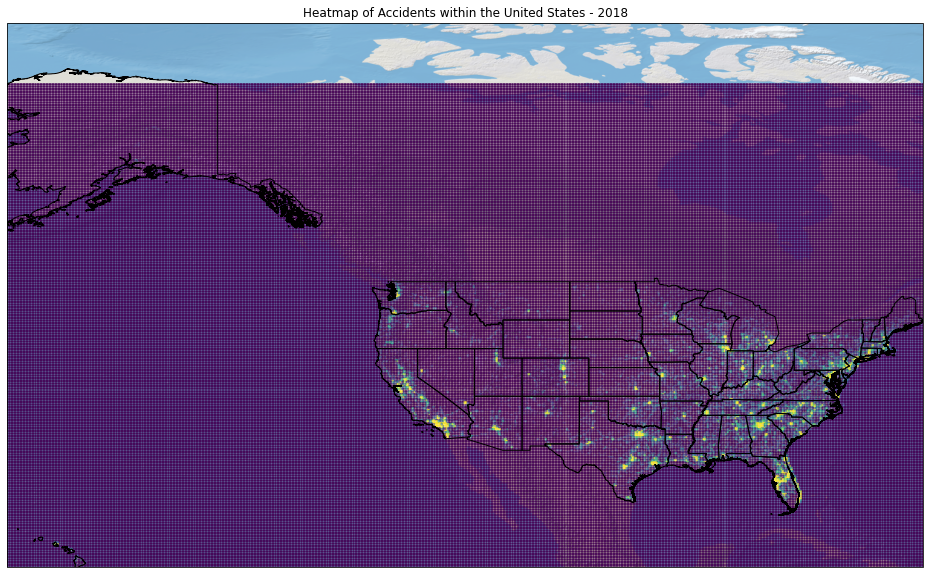

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.imshow(imread('shapes/NE1_50M_SR_W.tif'), origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])
ax.add_geometries(us_shapes, ccrs.PlateCarree(), edgecolor='black', facecolor='none')
#ax.add_feature(cfeature.BORDERS)
ax.set_extent(extent)

#heat_data = np.random.normal(0.0,1.0,size=(400,200))
heat_data = np.zeros((600,300))

for item in accident_tuples:
    _lat, _lon = \
                    heat_data.shape[1]*((max_lat-item[0])/regular_lat), \
                    heat_data.shape[0]*((abs(item[1])-abs(max_lng))/regular_lng)
    if heat_data[int(_lon)-1][int(_lat)-1] <= 10:
        heat_data[int(_lon)-1][int(_lat)-1] += 1
 
lat = np.linspace(extent[0],extent[1],heat_data.shape[0])
lon = np.linspace(extent[2],extent[3],heat_data.shape[1])
print(heat_data.shape, lat.shape, lon.shape)
Lat,Lon = np.meshgrid(lat,lon)
print(Lat.shape)
ax.pcolormesh(Lat,Lon,np.transpose(heat_data), alpha=0.5)
plt.title('Heatmap of Accidents within the United States - %i'%(2018))
plt.show()

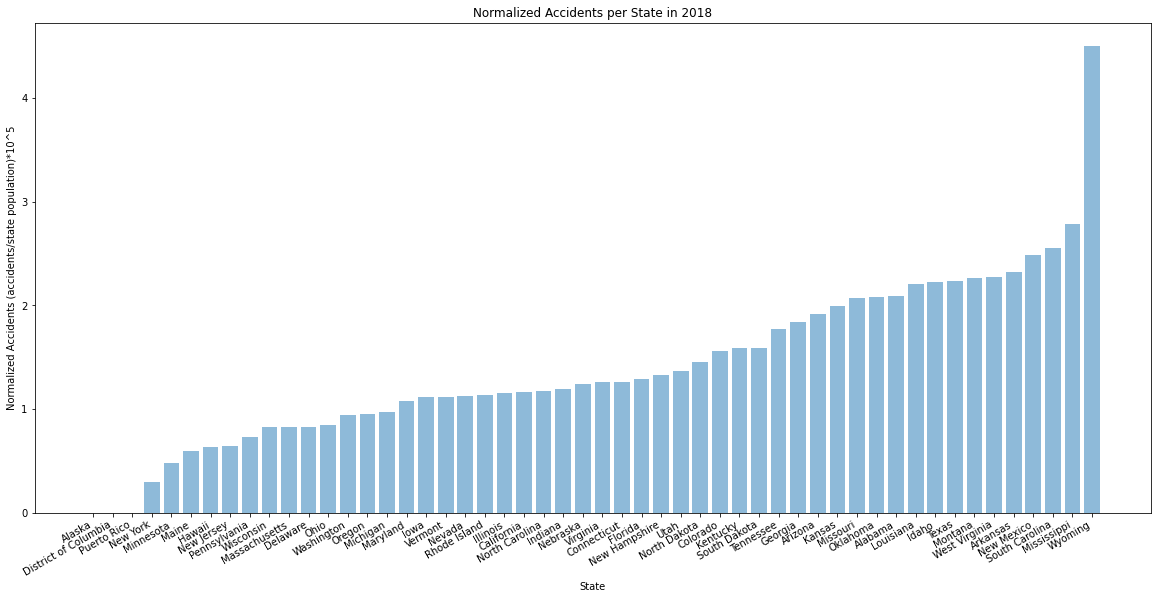

In [27]:
# Graphing accidents per state:
INTERSTATE_PREFIXES = ['I-']
HIGHWAY_PREFIXES = ['HWY', 'US-']

def checkIfPrefix(word, list_fix):
    for fix in list_fix:
        if fix in word:
            return True
    return False

state_dict = {}
for state in accidents:
    if state['STATE'] > 0:
        if checkIfPrefix(state['TWAY_ID'], INTERSTATE_PREFIXES):
            if state['STATE'] in state_dict:
                state_dict[state['STATE']] += 1
            else:
                state_dict[state['STATE']] = 1
        else:
            if not state['STATE'] in state_dict: 
                state_dict[state['STATE']] = 0
# temp:
state_dict[72] = 0
INTER_X, INTER_Y, TOTAL_Y = [], [], []

for item, row in popEst.iterrows():
    INTER_X.append(row[1])
    INTER_Y.append((state_dict[row[0]]/row[2])*(10**5))
    TOTAL_Y.append(state_dict[row[0]])
    
# sort it:
_INTER_X, _INTER_Y = [], []
INTER_COM = sorted(zip(INTER_Y,INTER_X))
for y,x in INTER_COM:
    _INTER_X.append(x)
    _INTER_Y.append(y)

fig,ax = plt.subplots(figsize=(20,10))
plt.bar(_INTER_X,_INTER_Y, align='center', alpha=0.5)
plt.xticks(rotation=45)
plt.title('Normalized Accidents per State in %i'%2018)
fig.autofmt_xdate()
ax.set_xlabel('State')
ax.set_ylabel('Normalized Accidents (accidents/state population)*10^5')
plt.show()